<a href="https://colab.research.google.com/github/mahipshah/Predicting-Football-Players-Position/blob/main/CS205_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Football (Soccer) Players' Position using FIFA 21 Dataset


Soccer is the world's most popular sport and just like everyone else, we love this game! It is not a part of the Big 3 sports in the US but it is slowly getting there. So the first choice in any team sport is deciding where to play. In the early days, most of the people starting out would love to score goals and play up front, but not everyone can play there and you need to defend as well. Everyone has different attributes which could be used in different positions, as a result we wanted to create a model which could predict the best position for a person based on their different soccer attributes.

For this purpose, we have used the [FIFA 21 dataset](https://www.kaggle.com/ekrembayar/fifa-21-complete-player-dataset) available at Kaggle. This dataset consists of various different attributes of all the players along with their preferred positions. One player can play in various position, like they can play on the right wing, left wing, as a striker and also as an attacking midfielder. This model will try to predict the best position for the player where they can be the most effective.

# Starting out from the back

First of all, we need to fetch the data. In this case, we are mounting our google drive which consists the csv file. After importing the appropriate libraries and fetching the data, we can do the preprocessing. We fetch the appropriate columns required for this project. We are not considering Goalkeeper for this project as it has a very different set of skills and will lead to scaled up accuracy. We handle the missing values by removing the rows because it won't really affect the data. Finally, we make the datatypes of all the attributes integer to maintain consistency.

In [ ]:
#Mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the Appropriate Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
#Fetch the data

data = pd.read_csv('drive/MyDrive/CS205_ML_Project/fifa21_male2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Check how the data looks

data.head(5)

,ID,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,Club Logo,Flag Photo,POT,Team & Contract,Height,Weight,foot,Growth,Joined,Loan Date End,Value,Wage,Release Clause,Contract,Attacking,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Skill,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Movement,Acceleration,Sprint Speed,Agility,...,W/F,SM,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,Gender
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,https://cdn.sofifa.com/teams/55/light_60.png,https://cdn.sofifa.com/flags/it.png,69,Udinese 2008 ~ 2016,"6'0""",181lbs,Left,0,"Jul 1, 2008",NaN,€625K,€7K,€0,2008 ~ 2016,313,75,50,59,71,58.0,338,73,65.0,60,69,71,347,68,74,68.0,...,3 ★,2★,Medium,High,2 ★,71,59,70,71,68,69,4,65+0,65+0,65+0,68+0,67+0,67+0,67+0,68+0,68+0,68+0,68+0,69+0,69+0,69+0,69+0,69+0,71+-2,70+-1,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,https://cdn.sofifa.com/teams/2013/light_60.png,https://cdn.sofifa.com/flags/es.png,71,KAS Eupen 2014 ~ 2019,"5'10""",143lbs,Right,0,"Jul 19, 2014",NaN,€600K,€7K,€1.1M,2014 ~ 2019,337,68,64,61,76,68.0,369,69,79.0,79,71,71,305,56,50,62.0,...,4 ★,3★,Medium,Medium,1 ★,53,69,73,69,58,63,4,67+1,67+1,67+1,67+0,68+0,68+0,68+0,67+0,70+1,70+1,70+1,68+1,70+1,70+1,70+1,68+1,62+1,66+1,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,https://cdn.sofifa.com/teams/1800/light_60.png,https://cdn.sofifa.com/flags/gb-eng.png,71,Coventry City 2016 ~ 2020,"5'9""",161lbs,Right,0,"Jan 7, 2016",NaN,€1.1M,€15K,€0,2016 ~ 2020,337,80,64,41,77,75.0,387,79,84.0,77,69,78,295,48,42,71.0,...,4 ★,4★,Medium,Low,2 ★,45,68,76,77,36,52,11,64+0,64+0,64+0,70+0,69+0,69+0,69+0,70+0,71+0,71+0,71+0,68+0,66+0,66+0,66+0,68+0,52+0,54+0,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,https://cdn.sofifa.com/teams/106/light_60.png,https://cdn.sofifa.com/flags/tt.png,82,Sunderland 2009,"5'11""",165lbs,Right,14,NaN,NaN,€0,€0,€0,2009,264,54,70,60,80,NaN,255,68,NaN,46,64,77,176,59,62,NaN,...,3 ★,1★,NaN,NaN,1 ★,61,66,66,69,47,60,3,67+0,67+0,67+0,66+0,67+0,67+0,67+0,66+0,70+0,70+0,70+0,66+0,68+0,68+0,68+0,66+0,56+0,65+0,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,https://cdn.sofifa.com/teams/101146/light_60.png,https://cdn.sofifa.com/flags/es.png,81,Vissel Kobe 2018 ~ 2021,"5'7""",150lbs,Right,0,"Jul 16, 2018",NaN,€5.5M,€12K,€7.2M,2018 ~ 2021,367,75,69,54,90,79.0,408,85,80.0,70,83,90,346,61,56,79.0,...,4 ★,4★,High,Medium,4 ★,58,70,85,85,63,59,149,72+3,72+3,72+3,79+0,79+0,79+0,79+0,79+0,82+-1,82+-1,82+-1,79+2,81+0,81+0,81+0,79+2,70+3,73+3,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


In [ ]:
#What are the different attributes

data.columns.values

array(['ID', 'Name', 'Age', 'OVA', 'Nationality', 'Club', 'BOV', 'BP',
       'Position', 'Player Photo', 'Club Logo', 'Flag Photo', 'POT',
       'Team & Contract', 'Height', 'Weight', 'foot', 'Growth', 'Joined',
       'Loan Date End', 'Value', 'Wage', 'Release Clause', 'Contract',
       'Attacking', 'Crossing', 'Finishing', 'Heading Accuracy',
       'Short Passing', 'Volleys', 'Skill', 'Dribbling', 'Curve',
       'FK Accuracy', 'Long Passing', 'Ball Control', 'Movement',
       'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance',
       'Power', 'Shot Power', 'Jumping', 'Stamina', 'Strength',
       'Long Shots', 'Mentality', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Defending',
       'Marking', 'Standing Tackle', 'Sliding Tackle', 'Goalkeeping',
       'GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning',
       'GK Reflexes', 'Total Stats', 'Base Stats', 'W/F', 'SM', 'A/W',
       'D/W', 'IR', 'PAC', 'SHO', 'P

In [ ]:
#Fetch the columns required for our purpose

cols = ['Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 
        'Dribbling', 'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control', 
        'Acceleration', 'Sprint Speed', 'Agility', 'Reactions', 'Balance', 
        'Shot Power', 'Jumping', 'Stamina', 'Strength', 'Long Shots', 
        'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 
        'Marking', 'Standing Tackle', 'Sliding Tackle', 'Position']
data = data[cols]
data.head()

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Position
0,75,50,59,71,58.0,73,65.0,60,69,71,68,74,68.0,69,68.0,74,68.0,69,68,68,72,69.0,63.0,66.0,50,NaN,70,69,69.0,LM
1,68,64,61,76,68.0,69,79.0,79,71,71,56,50,62.0,65,72.0,75,54.0,64,60,71,71,71.0,72.0,73.0,75,79.0,70,43,40.0,CM CAM CDM
2,80,64,41,77,75.0,79,84.0,77,69,78,48,42,71.0,59,75.0,72,58.0,29,56,69,69,39.0,69.0,74.0,66,NaN,35,34,30.0,CAM RM RW LM
3,54,70,60,80,NaN,68,NaN,46,64,77,59,62,NaN,55,NaN,63,NaN,51,66,59,59,70.0,72.0,NaN,70,NaN,34,41,NaN,NaN
4,75,69,54,90,79.0,85,80.0,70,83,90,61,56,79.0,75,75.0,67,40.0,58,62,70,58,70.0,78.0,93.0,71,89.0,68,57,56.0,CM CAM


In [ ]:
#We do not consider GK in this case

data['Position'] = data['Position'].str.strip()
data = data[data['Position'] != 'GK']

In [ ]:
#Check the number of rows and columns

data.shape

(15608, 30)

In [ ]:
#Remove the missing data

data = data.dropna()
data.shape

(14933, 30)

In [ ]:
#Verify there is no missing data

data.isnull().values.any()

False

In [ ]:
#Convert the datatype from float to int

c = data.select_dtypes('float').columns
data[c] = data[c].astype('int')

# No more center back playing as a striker.

When we were looking at the different positions, we found out certain weird positions like ACB, IVST, etc. Now, these positions are valid positions but they are not regularly used. First, we split all the positions a player can play into different rows. This will lead to a single player having multiple rows, but that is fine. While looking at the data, we found out that the last six rows consist of the weird positions we saw before. After double checking that they are the only rows with those positions, we remove these positions as they are not regularly used.

In [ ]:
#Check the different positions they can play

positions = data['Position'].str.split().apply(lambda x: x[0]).unique()
positions

array(['CM', 'ST', 'CF', 'LB', 'LM', 'CB', 'CDM', 'CAM', 'RM', 'RB', 'LW',
       'RW', 'LWB', 'RWB', 'ACB', 'IVST', 'ND', 'GK', 'IILB', 'IIRM'],
      dtype=object)

In [ ]:
#Duplicate rows by splitting all the positions a player can play

data_new = data.copy()
data_new.drop(data_new.index, inplace = True)

for i in positions:
  data_temp = data[data['Position'].str.contains(i)]
  data_temp['Position'] = i
  data_new = data_new.append(data_temp, ignore_index = True)

data_new.iloc[::500, :]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Position
0,68,64,61,76,68,69,79,79,71,71,56,50,62,65,72,75,54,64,60,71,71,71,72,73,75,79,70,43,40,CM
500,77,72,67,79,73,80,78,56,77,79,66,70,77,73,72,77,63,70,67,77,71,68,75,78,62,75,67,66,65,CM
1000,61,51,54,67,50,61,61,58,63,65,66,67,70,61,71,57,60,68,71,51,65,64,57,63,61,63,60,65,61,CM
1500,62,55,55,68,44,66,64,64,65,69,54,39,59,71,63,64,58,75,66,62,64,64,61,65,48,66,58,66,61,CM
2000,45,44,63,70,30,58,46,35,63,69,50,61,55,60,53,65,61,73,72,58,60,58,52,67,38,72,68,69,62,CM
2500,55,66,71,73,48,68,44,45,70,69,60,58,69,65,59,57,72,69,73,56,61,68,65,68,49,70,70,72,66,CM
3000,59,57,49,81,55,71,81,59,77,73,79,73,80,65,84,81,73,87,66,63,67,61,55,69,53,73,69,71,67,CM
3500,72,74,61,78,71,75,76,71,75,76,65,68,72,72,70,77,68,48,70,75,73,47,76,74,77,86,57,30,26,ST
4000,51,75,77,69,76,62,68,46,54,74,41,54,61,74,35,80,57,66,87,71,61,23,78,65,72,70,55,32,24,ST
4500,35,58,58,51,55,59,43,41,31,59,72,68,66,57,61,67,70,60,80,49,73,19,58,46,57,57,27,21,23,ST


In [ ]:
#The last few positions look weird

data_new.tail(10)

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Position
26050,52,38,52,57,29,41,24,25,45,54,56,59,41,50,63,39,62,53,62,28,41,53,21,28,31,43,42,55,49,RWB
26051,49,30,43,42,34,50,36,31,38,49,71,68,58,48,57,35,62,60,62,32,51,48,48,40,38,45,48,51,50,RWB
26052,55,21,57,56,29,56,44,33,41,62,77,74,61,61,75,66,73,67,61,27,66,61,48,28,39,58,58,65,60,RWB
26053,52,33,48,51,29,52,43,37,46,43,73,76,75,54,78,31,72,75,63,34,59,52,51,33,41,47,51,59,56,RWB
26054,59,51,63,53,50,58,68,71,53,59,50,37,64,60,59,63,76,66,84,63,64,61,51,54,50,63,59,60,59,ACB
26055,49,62,53,59,59,71,54,31,32,64,84,82,78,58,73,64,67,55,57,58,60,26,60,53,60,61,32,33,21,IVST
26056,60,59,54,65,60,60,63,62,60,60,64,67,63,60,74,65,63,60,49,62,59,59,56,57,50,49,61,64,62,ND
26057,12,11,14,27,14,14,16,13,25,21,43,49,38,61,54,44,58,23,68,17,17,23,18,48,24,53,7,14,17,GK
26058,49,27,45,55,26,53,47,25,51,50,70,68,69,54,69,27,57,60,49,30,47,53,51,46,31,46,50,55,54,IILB
26059,53,36,37,49,43,62,45,37,50,57,71,72,68,43,76,56,52,53,46,41,34,22,45,51,59,49,24,29,34,IIRM


In [ ]:
#Double check the count of positions

data_new['Position'].value_counts()

CM      3470
CB      3243
ST      3224
CDM     2449
LM      2244
RM      2158
CAM     2113
LB      1806
RB      1736
RW      1325
LW      1317
CF       384
LWB      294
RWB      291
ND         1
ACB        1
IILB       1
IIRM       1
IVST       1
GK         1
Name: Position, dtype: int64

In [ ]:
#Remove the weird positions

data_new = data_new[~data_new['Position'].isin(['ND', 'GK', 'IILB', 'IIRM', 'ACB', 'IVST'])]

In [ ]:
#Verify

data_new['Position'].value_counts()

CM     3470
CB     3243
ST     3224
CDM    2449
LM     2244
RM     2158
CAM    2113
LB     1806
RB     1736
RW     1325
LW     1317
CF      384
LWB     294
RWB     291
Name: Position, dtype: int64

# Into the final third.

Now that we have the correct data, we can start plotting. We will plot all the attributes for one of the positions. Just like everyone else, let's pick the striker. We can see the different Attributes for all the strikers. They seem pretty similar other than certain variations. The striker is a weird position as there are different kinds of strikers. So the two main ones are: Target Man and Running in behind. So the build for a target man is strong, tall and physical. While, the other type of striker is fast and tries to beat the defenders for pace. So, certain attributes might be quite different for both of them. We also plot after normalizing the data which looks a lot better.

Text(26.3, 95, 'Attributes')

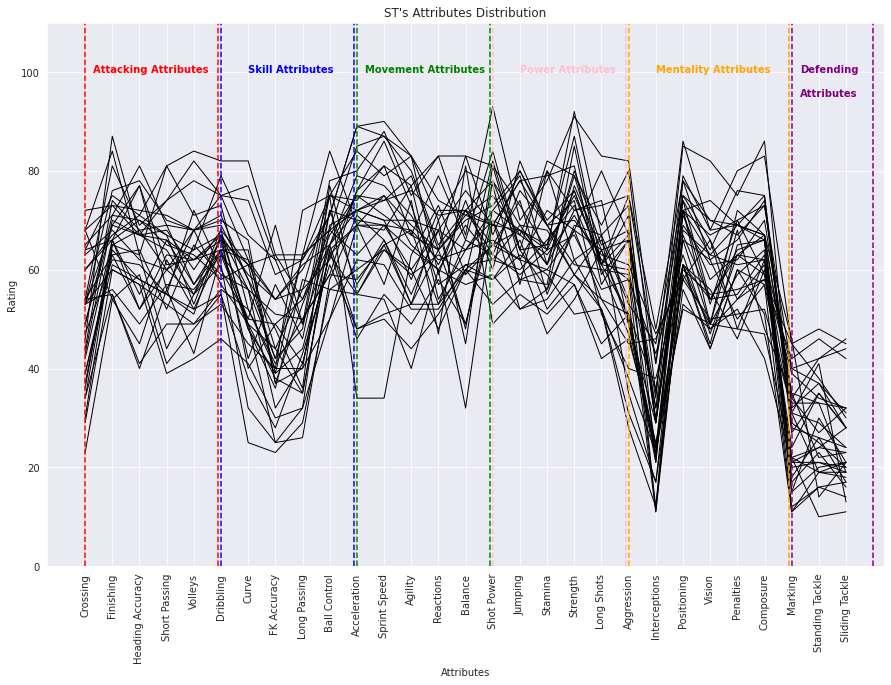

In [ ]:
#Plot the attributes for a striker

cols = [c for c in data_new.columns if c != 'Position']

fig, ax = plt.subplots()
data_new_ST = data_new[data_new['Position'] == 'ST'].iloc[::100, :-1]
data_new_ST.T.plot.line(color = 'black', figsize = (15, 10), legend = False, ylim = (0, 110), title = "ST's Attributes Distribution", ax = ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation = 90)

for l in ax.lines:
  l.set_linewidth(1)

ax.axvline(0, color = 'red', linestyle = '--')
ax.axvline(4.9, color = 'red', linestyle = '--')

ax.axvline(5, color = 'blue', linestyle = '--')
ax.axvline(9.9, color = 'blue', linestyle = '--')

ax.axvline(10, color = 'green', linestyle = '--')
ax.axvline(14.9, color = 'green', linestyle = '--')

ax.axvline(15, color = 'pink', linestyle = '--')
ax.axvline(19.9, color = 'pink', linestyle = '--')

ax.axvline(20, color = 'orange', linestyle = '--')
ax.axvline(25.9, color = 'orange', linestyle = '--')

ax.axvline(26, color = 'purple', linestyle = '--')
ax.axvline(29, color = 'purple', linestyle = '--')

ax.text(0.3, 100, 'Attacking Attributes', color = 'red', weight = 'bold')
ax.text(6, 100, 'Skill Attributes', color = 'blue', weight = 'bold')
ax.text(10.3, 100, 'Movement Attributes', color = 'green', weight = 'bold')
ax.text(16, 100, 'Power Attributes', color = 'pink', weight = 'bold')
ax.text(21, 100, 'Mentality Attributes', color = 'orange', weight = 'bold')
ax.text(26.3, 100, 'Defending', color = 'purple', weight = 'bold')
ax.text(26.3, 95, 'Attributes', color = 'purple', weight = 'bold')

Text(26.3, 0.068, 'Attributes')

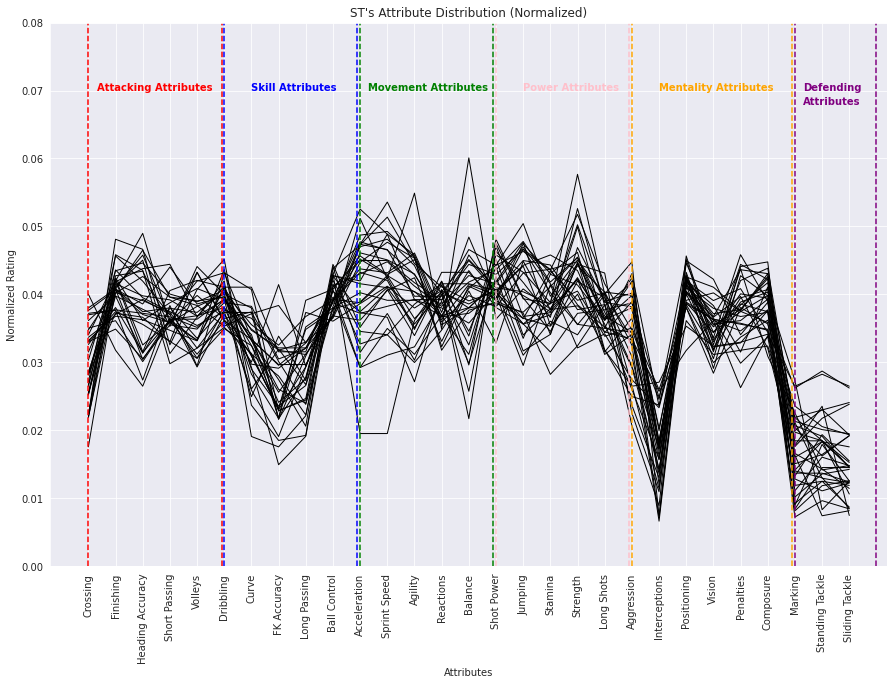

In [ ]:
#Normalize the data and plot again

data_new_ST_normalized = data_new_ST.div(data_new_ST.sum(axis = 1), axis = 0)

fig, ax = plt.subplots()
data_new_ST_normalized.T.plot.line(color = 'black', figsize = (15, 10), legend = False, ylim = (0, 0.08), title = "ST's Attribute Distribution (Normalized)", ax = ax)

ax.set_xlabel('Attributes')
ax.set_ylabel('Normalized Rating')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(labels = cols, rotation = 90)

for l in ax.lines:
  l.set_linewidth(1)

ax.axvline(0, color = 'red', linestyle = '--')
ax.axvline(4.9, color = 'red', linestyle = '--')

ax.axvline(5, color = 'blue', linestyle = '--')
ax.axvline(9.9, color = 'blue', linestyle = '--')

ax.axvline(10, color = 'green', linestyle = '--')
ax.axvline(14.9, color = 'green', linestyle = '--')

ax.axvline(15, color = 'pink', linestyle = '--')
ax.axvline(19.9, color = 'pink', linestyle = '--')

ax.axvline(20, color = 'orange', linestyle = '--')
ax.axvline(25.9, color = 'orange', linestyle = '--')

ax.axvline(26, color = 'purple', linestyle = '--')
ax.axvline(29, color = 'purple', linestyle = '--')

ax.text(0.3, 0.07, 'Attacking Attributes', color = 'red', weight = 'bold')
ax.text(6, 0.07, 'Skill Attributes', color = 'blue', weight = 'bold')
ax.text(10.3, 0.07, 'Movement Attributes', color = 'green', weight = 'bold')
ax.text(16, 0.07, 'Power Attributes', color = 'pink', weight = 'bold')
ax.text(21, 0.07, 'Mentality Attributes', color = 'orange', weight = 'bold')
ax.text(26.3, 0.07, 'Defending', color = 'purple', weight = 'bold')
ax.text(26.3, 0.068, 'Attributes', color = 'purple', weight = 'bold')

# Attackers vs Defenders


Now, we convert the problem into a binary classification problem. The two classes are Attacker and Defender. Striker, Wingers, Center Forward, Attacking Midfielders and Central Midfielders are part of Attackers and are labeled 1. While, Defensive Midfielders, Fullbacks, Wingbacks and Centerbacks are part of Defenders and are labeled 0. 

In [ ]:
#Make it a binary problem by distributing into two positions, attacker(1) or defender(0)

data_new_normalized = data_new.iloc[:, :-1].div(data_new.iloc[:, :-1].sum(axis = 1), axis = 0)
mapping = {'ST' : 1, 'RW' : 1, 'LW' : 1, 'CF' : 1, 'CAM' : 1, 'RM' : 1, 'LM' : 1, 'CM' : 1,
          'CDM' : 0, 'LB' : 0, 'LWB' : 0, 'RB' : 0, 'RWB' : 0, 'CB' : 0}

data_new_normalized['Position'] = data_new['Position']
data_new_normalized = data_new_normalized.replace({'Position' : mapping})

data_new_normalized.iloc[::1000, ]

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Position
0,0.035251,0.033178,0.031623,0.039399,0.035251,0.035770,0.040954,0.040954,0.036807,0.036807,0.029031,0.025920,0.032141,0.033696,0.037325,0.038880,0.027994,0.033178,0.031104,0.036807,0.036807,0.036807,0.037325,0.037843,0.038880,0.040954,0.036288,0.022291,0.020736,1
1000,0.034040,0.028460,0.030134,0.037388,0.027902,0.034040,0.034040,0.032366,0.035156,0.036272,0.036830,0.037388,0.039062,0.034040,0.039621,0.031808,0.033482,0.037946,0.039621,0.028460,0.036272,0.035714,0.031808,0.035156,0.034040,0.035156,0.033482,0.036272,0.034040,1
2000,0.026834,0.026237,0.037567,0.041741,0.017889,0.034586,0.027430,0.020871,0.037567,0.041145,0.029815,0.036374,0.032797,0.035778,0.031604,0.038760,0.036374,0.043530,0.042934,0.034586,0.035778,0.034586,0.031008,0.039952,0.022660,0.042934,0.040549,0.041145,0.036971,1
3000,0.029530,0.028529,0.024525,0.040541,0.027528,0.035536,0.040541,0.029530,0.038539,0.036537,0.039540,0.036537,0.040040,0.032533,0.042042,0.040541,0.036537,0.043544,0.033033,0.031532,0.033534,0.030531,0.027528,0.034535,0.026527,0.036537,0.034535,0.035536,0.033534,1
4000,0.029010,0.042662,0.043800,0.039249,0.043231,0.035267,0.038680,0.026166,0.030717,0.042093,0.023322,0.030717,0.034699,0.042093,0.019909,0.045506,0.032423,0.037543,0.049488,0.040387,0.034699,0.013083,0.044369,0.036974,0.040956,0.039818,0.031286,0.018203,0.013652,1
5000,0.019189,0.040570,0.038925,0.038377,0.034539,0.036732,0.029605,0.021382,0.031250,0.041118,0.037281,0.037281,0.038925,0.040570,0.034539,0.044956,0.040570,0.038377,0.049342,0.037281,0.045504,0.010417,0.043860,0.038377,0.044408,0.040570,0.021382,0.012610,0.012061,1
6000,0.026694,0.047228,0.050650,0.033539,0.039699,0.036277,0.026694,0.021903,0.026694,0.041752,0.036277,0.043121,0.036277,0.042437,0.031485,0.050650,0.041068,0.036961,0.057495,0.036961,0.021903,0.007529,0.043806,0.036961,0.044490,0.043806,0.010951,0.015058,0.011636,1
7000,0.018131,0.043236,0.036262,0.029986,0.042538,0.045328,0.023013,0.018828,0.021618,0.041841,0.047420,0.050907,0.040446,0.040446,0.040446,0.036960,0.046025,0.041841,0.056485,0.041841,0.043236,0.016039,0.038354,0.029289,0.039052,0.031381,0.013947,0.016736,0.008368,1
8000,0.039390,0.015248,0.032402,0.037484,0.017789,0.036213,0.031131,0.018424,0.034307,0.037484,0.049555,0.046379,0.043202,0.033672,0.038755,0.019695,0.045743,0.048920,0.043202,0.015883,0.040025,0.037484,0.032402,0.034307,0.024778,0.029225,0.037484,0.040661,0.038755,0
9000,0.038185,0.038738,0.028777,0.037631,0.036525,0.037631,0.038185,0.029884,0.032097,0.037078,0.040952,0.040398,0.040398,0.038185,0.039845,0.036525,0.039845,0.033758,0.029884,0.037631,0.034311,0.022136,0.038738,0.037631,0.035971,0.036525,0.019923,0.021583,0.021029,1


# In front of goal...

Now, we are ready to test the model. We will use scikit-learn's train_test_split procedure to split the data into random train and test subsets. We will apply Logistic Regression to the data and find the accuracy, confusion matrix and f-1 score.

In [ ]:
#Split the data into training and testing subsets

X_train, X_test, y_train, y_test = train_test_split(data_new_normalized.iloc[:, :-1], data_new_normalized.iloc[:, -1], random_state = 0)

print('X train shape: {}'.format(X_train.shape))
print('X test shape: {}'.format(X_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

X train shape: (19540, 29)
X test shape: (6514, 29)
y train shape: (19540,)
y test shape: (6514,)


In [ ]:
#Apply Logistic Regression to get accuracy, confusion matrix and f-1 score

lr = LogisticRegression(random_state = 0)
clf = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
acc = clf.score(X_test, y_test)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test, y_pred)))
print('F-1 Score: {}'.format(f1_score(y_test, y_pred)))
print('Logistic Regression Accuracy: {}'.format(acc))

Confusion Matrix: [[1853  625]
 [ 390 3646]]
F-1 Score: 0.877813891898399
Logistic Regression Accuracy: 0.8441817623579981


# Hit the crossbar?

So, we got an accuracy of about 84% which is not bad. Now, let's just see which attributes have the most importance and try to reduce the features. So, we get the importance of different features and select the top 10 features and run the model again.

In [ ]:
#Find the important features

coef_list = list(sorted(zip(X_train.columns, abs(clf.coef_[0])), key = lambda x: -x[1]))
coef_table = pd.DataFrame(np.array(coef_list).reshape(-1, 2), columns = ['Attributes', 'Coef'])

print(coef_table)

          Attributes                Coef
0     Sliding Tackle   20.70978325533794
1    Standing Tackle  19.815880649821725
2      Interceptions  19.538896193349256
3            Marking    18.4534652402676
4          Finishing  15.593244706255842
5            Volleys   10.76754958211552
6        Positioning  10.592836908969675
7         Long Shots  10.544750917203315
8         Aggression   8.824763375302402
9             Vision   8.101325884573054
10         Penalties   7.824180062659288
11          Strength  7.0419357898798935
12         Dribbling   6.866426681410918
13        Shot Power   6.372270264751396
14  Heading Accuracy   6.260210887716764
15       FK Accuracy   6.104010817471916
16             Curve  5.8525971922613005
17           Jumping   5.561754614702825
18           Agility   5.122847924296687
19           Balance   3.874324301337481
20      Ball Control  3.8740570041091926
21      Acceleration   3.414302860113276
22           Stamina  3.0640356958167443
23      Sprint S

In [ ]:
#Apply Logistic Regression on top 10 features

target_cols = coef_table[:10]['Attributes'].tolist()

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data_new_normalized[target_cols].iloc[:, :-1], data_new_normalized.iloc[:, -1], random_state = 0)
clf_1 = lr.fit(X_train_1, y_train_1)
y_pred_1 = lr.predict(X_test_1)
acc_1 = clf_1.score(X_test_1, y_test_1)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test_1, y_pred_1)))
print('F-1 Score: {}'.format(f1_score(y_test_1, y_pred_1)))
print('Logistic Regression Accuracy (10 features): {}'.format(acc_1))

Confusion Matrix: [[1869  609]
 [ 402 3634]]
F-1 Score: 0.8778838023915932
Logistic Regression Accuracy (10 features): 0.8447958243782622


# Second chance?

Applying Logistic Regression to the top 10 features gives us a similar accuracy as before. If we think about it, there must be some correlation between different features. So we should probably use a dimension reduction technique such as PCA for example? For the next part of the code, we referred the [following tutorial](https://www.kaggle.com/arthurtok/principal-component-analysis-with-kmeans-visuals). We get the correlation between different attributes, find the number of components required for PCA and then apply PCA.

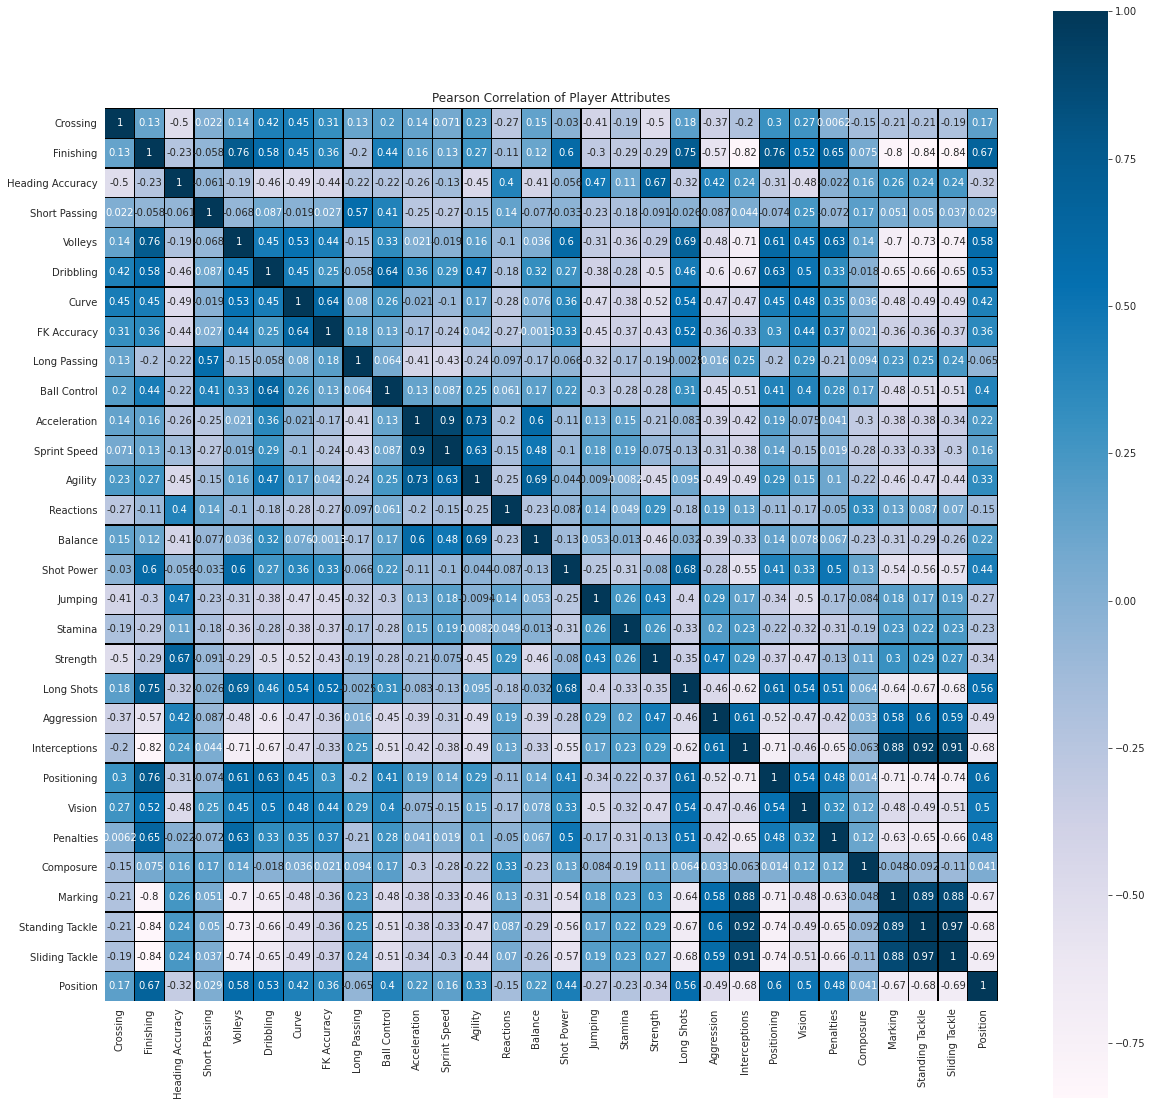

In [ ]:
#Find correlation between the attributes

f, ax = plt.subplots(figsize = (20, 20))

plt.title('Pearson Correlation of Player Attributes')

sns.heatmap(data_new_normalized.corr(), linewidths = 0.25, vmax = 1.0, square = True, cmap = 'PuBu', linecolor = 'black', annot = True)

[(0, 49.43890387898591), (1, 62.05149620931246), (2, 72.88190677417316), (3, 75.70271229567804), (4, 78.17542900678012), (5, 80.35278181581137), (6, 82.27053818996802), (7, 84.13753584377297), (8, 85.94239016897252), (9, 87.4311110712357), (10, 88.64503170912084), (11, 89.75066716266072), (12, 90.85402182033286), (13, 91.87410280194062), (14, 92.84318091205553), (15, 93.73977099510756), (16, 94.55280314618426), (17, 95.30875999568242), (18, 96.02447040324937), (19, 96.68871734091735), (20, 97.32348558716768), (21, 97.91320635254885), (22, 98.44753411374995), (23, 98.9090920776228), (24, 99.24263149305197), (25, 99.54753607502757), (26, 99.80890810117027), (27, 100.00000000000003), (28, 100.00000000000003)]


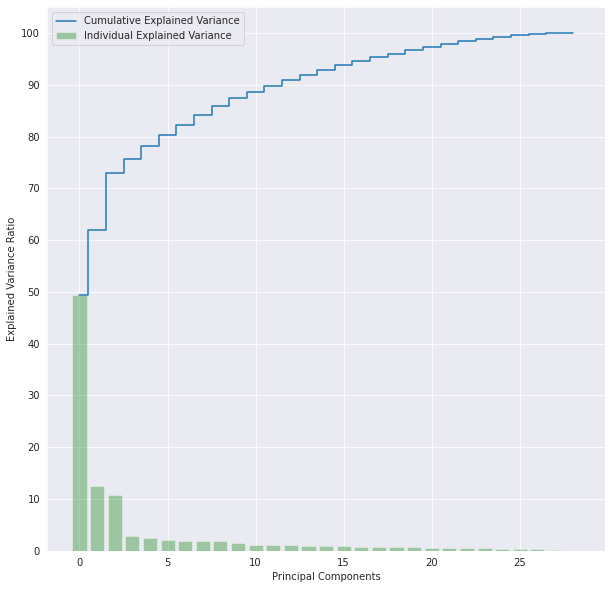

In [ ]:
#Find the number of components required for pca

covariance_matrix = np.cov(data_new_normalized.iloc[:, :-1].T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)

total = sum(eigen_values)
explained_variance = [(i / total) * 100 for i in sorted(eigen_values, reverse = True)]
cumulative_explained_variance = np.cumsum(explained_variance)

print(list(zip(range(29), cumulative_explained_variance)))

plt.figure(figsize = (10, 10))
plt.bar(range(len(explained_variance)), explained_variance, alpha = 0.3333, align = 'center', label = 'Individual Explained Variance', color = 'g')
plt.step(range(len(explained_variance)), cumulative_explained_variance, where = 'mid', label = 'Cumulative Explained Variance')

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.yticks(ticks = [i for i in range(0, 110, 10)])
plt.legend(loc = 'best')
plt.show()

17 components are needed for more than 95% of explained variance level. Thus let's apply PCA with 17 components.

In [ ]:
#Apply PCA with 17 components

pca = PCA(n_components = 17)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_new_normalized.iloc[:, :-1], data_new_normalized.iloc[:, -1], random_state = 0)

X_train_2_pca = pca.fit_transform(X_train_2)
X_train_2_pca = pd.DataFrame(X_train_2_pca)

X_test_2_pca = pca.transform(X_test_2)

clf_17d = lr.fit(X_train_2_pca, y_train_2)
y_pred_2 = lr.predict(X_test_2_pca)
acc_17d = clf_17d.score(X_test_2_pca, y_test_2)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test_2, y_pred_2)))
print('F-1 Score: {}'.format(f1_score(y_test_2, y_pred_2)))
print('Logistic Regression Accuracy with PCA (17 components): {}'.format(acc_17d))

Confusion Matrix: [[1853  625]
 [ 390 3646]]
F-1 Score: 0.877813891898399
Logistic Regression Accuracy with PCA (17 components): 0.8441817623579981


# Going sideways

PCA gives a similar accuracy as Logistic Regression. One thing to consider is that PCA does not consider class labels but LDA (Linear Discriminant Analysis) does consider class labels for dimension reduction. Let us try to see how it works. We find the number of components required for LDA and then apply it to the data. 

In [ ]:
#Find number of components required for LDA.

lda = LDA()

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(data_new_normalized.iloc[:, :-1], data_new_normalized.iloc[:, -1], random_state = 0)

X_lda = lda.fit(X_train_3, y_train_3)

lda_var_ratios = lda.explained_variance_ratio_

def select_n_components(var_ratio, goal_var: float) -> int:
  total_variance = 0.0
  n_components = 0

  for explained_variance in var_ratio:
    total_variance += explained_variance
    n_components += 1
    if total_variance >= goal_var:
      break
  
  return n_components

print('Number of components needed to explain 95% variance: {}'.format(select_n_components(lda_var_ratios, 0.95)))

Number of components needed to explain 95% variance: 1


In [ ]:
#Apply LDA with 1 component

lda_n = LDA(n_components = 1)

X_train_3_lda = lda_n.fit_transform(X_train_3, y_train_3)
X_train_3_lda = pd.DataFrame(X_train_3_lda)

X_test_3_lda = lda_n.transform(X_test_3)

clf_3d = lr.fit(X_train_3_lda, y_train_3)
y_pred_3 = lr.predict(X_test_3_lda)
acc_3d = clf_3d.score(X_test_3_lda, y_test_2)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test_3, y_pred_3)))
print('F-1 Score: {}'.format(f1_score(y_test_3, y_pred_3)))
print('Logistic Regression Accuracy with LDA (3 components): {}'.format(acc_3d))

Confusion Matrix: [[2015  463]
 [ 470 3566]]
F-1 Score: 0.8843149411035338
Logistic Regression Accuracy with LDA (3 components): 0.8567700337734111


# GOOOOOAAAAALLLLLL!!!

Logistic Regression with LDA gives us an accuracy of about 86% which is better than basic Logistic Regression.

# On to the next game

For future work, we can try other classification methods like Naive Bayes, Stochastic Gradient Descent and so on. We can also try to predict the correct position rather than just attacker or defender by making it a multi-classification problem. From this project, we learn about how different attributes impact the position a player plays and how different dimensionality reduction techniques can improve a model.

# The next game

The next part of the code is after the submission for CS 205 Machine Learning Project. We will try to predict the position based on the position and will group similar positions together like LW, RW, LM and RM are essentially the same position for our project and so they will be grouped together. Similarly, ST, CF are grouped together. LB, LWB, RB and RWB are grouped together. The interesting position are CAM, CM and CDM as they are all central midfielders but they all have different roles to play and as a result, they should belong to different classes.

In [ ]:
#Try to predict the correct position

data_new_normalized_1 = data_new.iloc[:, :-1].div(data_new.iloc[:, :-1].sum(axis = 1), axis = 0)
mapping = {'ST' : 0, 'RW' : 1, 'LW' : 1, 'CF' : 0, 'CAM' : 2, 'RM' : 1, 'LM' : 1, 'CM' : 3,
          'CDM' : 4, 'LB' : 5, 'LWB' : 5, 'RB' : 5, 'RWB' : 5, 'CB' : 6}

data_new_normalized_1['Position'] = data_new['Position']
data_new_normalized_1 = data_new_normalized_1.replace({'Position' : mapping})

data_new_normalized_1.iloc[::1000, ]

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,Position
0,0.035251,0.033178,0.031623,0.039399,0.035251,0.035770,0.040954,0.040954,0.036807,0.036807,0.029031,0.025920,0.032141,0.033696,0.037325,0.038880,0.027994,0.033178,0.031104,0.036807,0.036807,0.036807,0.037325,0.037843,0.038880,0.040954,0.036288,0.022291,0.020736,3
1000,0.034040,0.028460,0.030134,0.037388,0.027902,0.034040,0.034040,0.032366,0.035156,0.036272,0.036830,0.037388,0.039062,0.034040,0.039621,0.031808,0.033482,0.037946,0.039621,0.028460,0.036272,0.035714,0.031808,0.035156,0.034040,0.035156,0.033482,0.036272,0.034040,3
2000,0.026834,0.026237,0.037567,0.041741,0.017889,0.034586,0.027430,0.020871,0.037567,0.041145,0.029815,0.036374,0.032797,0.035778,0.031604,0.038760,0.036374,0.043530,0.042934,0.034586,0.035778,0.034586,0.031008,0.039952,0.022660,0.042934,0.040549,0.041145,0.036971,3
3000,0.029530,0.028529,0.024525,0.040541,0.027528,0.035536,0.040541,0.029530,0.038539,0.036537,0.039540,0.036537,0.040040,0.032533,0.042042,0.040541,0.036537,0.043544,0.033033,0.031532,0.033534,0.030531,0.027528,0.034535,0.026527,0.036537,0.034535,0.035536,0.033534,3
4000,0.029010,0.042662,0.043800,0.039249,0.043231,0.035267,0.038680,0.026166,0.030717,0.042093,0.023322,0.030717,0.034699,0.042093,0.019909,0.045506,0.032423,0.037543,0.049488,0.040387,0.034699,0.013083,0.044369,0.036974,0.040956,0.039818,0.031286,0.018203,0.013652,0
5000,0.019189,0.040570,0.038925,0.038377,0.034539,0.036732,0.029605,0.021382,0.031250,0.041118,0.037281,0.037281,0.038925,0.040570,0.034539,0.044956,0.040570,0.038377,0.049342,0.037281,0.045504,0.010417,0.043860,0.038377,0.044408,0.040570,0.021382,0.012610,0.012061,0
6000,0.026694,0.047228,0.050650,0.033539,0.039699,0.036277,0.026694,0.021903,0.026694,0.041752,0.036277,0.043121,0.036277,0.042437,0.031485,0.050650,0.041068,0.036961,0.057495,0.036961,0.021903,0.007529,0.043806,0.036961,0.044490,0.043806,0.010951,0.015058,0.011636,0
7000,0.018131,0.043236,0.036262,0.029986,0.042538,0.045328,0.023013,0.018828,0.021618,0.041841,0.047420,0.050907,0.040446,0.040446,0.040446,0.036960,0.046025,0.041841,0.056485,0.041841,0.043236,0.016039,0.038354,0.029289,0.039052,0.031381,0.013947,0.016736,0.008368,0
8000,0.039390,0.015248,0.032402,0.037484,0.017789,0.036213,0.031131,0.018424,0.034307,0.037484,0.049555,0.046379,0.043202,0.033672,0.038755,0.019695,0.045743,0.048920,0.043202,0.015883,0.040025,0.037484,0.032402,0.034307,0.024778,0.029225,0.037484,0.040661,0.038755,5
9000,0.038185,0.038738,0.028777,0.037631,0.036525,0.037631,0.038185,0.029884,0.032097,0.037078,0.040952,0.040398,0.040398,0.038185,0.039845,0.036525,0.039845,0.033758,0.029884,0.037631,0.034311,0.022136,0.038738,0.037631,0.035971,0.036525,0.019923,0.021583,0.021029,1


# Starting again

Now, we will use some of the machine learning algorithms we used before again on the newly multiclassified problem. We will also try to see the performance of some new algorithms like Random Forest and Linear SVC with OneVSRest classifier for the multiclassification problem.

In [ ]:
X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(data_new_normalized_1.iloc[:, :-1], data_new_normalized_1.iloc[:, -1], random_state = 0)

clf_mc = lr.fit(X_train_mc, y_train_mc)
y_pred_mc = lr.predict(X_test_mc)
acc_mc = clf_mc.score(X_test_mc, y_test_mc)
print('Confusion Matrix: {}'.format(confusion_matrix(y_test_mc, y_pred_mc)))
#print('F-1 Score: {}'.format(f1_score(y_test_mc, y_pred_mc)))
print('Logistic Regression Accuracy: {}'.format(acc_mc))

Confusion Matrix: [[ 365  521    0    0    0    1    1]
 [  41 1511    0   10    0  187    4]
 [  12  499    0   16    0    3    1]
 [   0  511    0  156    0  143   54]
 [   0  174    0  145    0  184  127]
 [   1  242    0   15    0  696   84]
 [   0   10    0   20    0  156  624]]
Logistic Regression Accuracy: 0.5145839729812711


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state = 0).fit(X_train_mc, y_train_mc)
acc_rf = clf_rf.score(X_test_mc, y_test_mc)

print('Random Forest Accuracy: {}'.format(acc_rf))

Random Forest Accuracy: 0.4313785692354928


In [ ]:
 from sklearn.multiclass import OneVsRestClassifier
 from sklearn.svm import LinearSVC

 clf_ovr = OneVsRestClassifier(LinearSVC(random_state = 0)).fit(X_train_mc, y_train_mc)
 acc_ovr = clf_ovr.score(X_test_mc, y_test_mc)
 print('One vs Rest Classifier: {}'.format(acc_ovr))

One vs Rest Classifier: 0.577985876573534


# Need to make some changes

So the algorithms did not give us the accuracy we desired. Logistic Regression gives us an accuracy of about 51%. Random Forest Classifier gives us a very disappointing accuracy of just 43%. Linear SVC with OneVsRest Classifier gives us an improved accuracy of about 58% but that is still not good enough. So, do we need more data? Maybe the imbalance in the different positions is the problem. Let us try using SMOTE to oversample the data and get same value counts for all the class labels.

In [ ]:
data_new_normalized_1['Position'].value_counts()

1    7044
5    4127
0    3608
3    3470
6    3243
4    2449
2    2113
Name: Position, dtype: int64

Class = 3, n = 3470 (13.318%)
Class = 0, n = 3608 (13.848%)
Class = 5, n = 4127 (15.840%)
Class = 1, n = 7044 (27.036%)
Class = 6, n = 3243 (12.447%)
Class = 4, n = 2449 (9.400%)
Class = 2, n = 2113 (8.110%)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


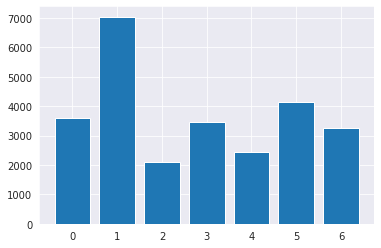

In [ ]:
import imblearn
from sklearn.preprocessing import LabelEncoder
from collections import Counter

y = data_new_normalized_1.iloc[:, -1]
y = LabelEncoder().fit_transform(y)

counter = Counter(y)
for k, v in counter.items():
  per = v / len(y) * 100
  print('Class = %d, n = %d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Class = 3, n = 7044 (14.286%)
Class = 0, n = 7044 (14.286%)
Class = 5, n = 7044 (14.286%)
Class = 1, n = 7044 (14.286%)
Class = 6, n = 7044 (14.286%)
Class = 4, n = 7044 (14.286%)
Class = 2, n = 7044 (14.286%)


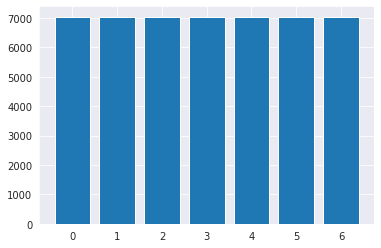

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X = data_new_normalized_1.iloc[:, :-1]

X, y = oversample.fit_resample(X, y)

counter = Counter(y)
for k, v in counter.items():
  per = v / len(y) * 100
  print('Class = %d, n = %d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
X_train_mc_1, X_test_mc_1, y_train_mc_1, y_test_mc_1 = train_test_split(X, y, random_state = 0)

clf_mc_1 = lr.fit(X_train_mc_1, y_train_mc_1)
y_pred_mc_1 = lr.predict(X_test_mc_1)
acc_mc_1 = clf_mc_1.score(X_test_mc_1, y_test_mc_1)

print('Confusion Matrix: {}'.format(confusion_matrix(y_pred_mc_1, y_test_mc_1)))
print('Accuracy: {}'.format(acc_mc_1))

Confusion Matrix: [[1397  399  261   13    0    2    1]
 [ 155  548  322   73    6   43    0]
 [ 144  360  800  297   36    7    0]
 [  18  114  287  603  443  138    7]
 [   5   26   69  525  849  141  172]
 [   6  267   25  142  159 1239  213]
 [   2   11    2   75  277  228 1420]]
Accuracy: 0.5561774965522837


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
 clf_ovr_1 = OneVsRestClassifier(LinearSVC(random_state = 0)).fit(X_train_mc_1, y_train_mc_1)
 acc_ovr_1 = clf_ovr.score(X_test_mc_1, y_test_mc_1)
 print('One vs Rest Classifier: {}'.format(acc_ovr_1))

One vs Rest Classifier: 0.49963494767583355


# Scoring in both nets

Now, this is very interesting to see. After using SMOTE to get same counts of all the class labels, we get an improved accuracy for Logistic Regression with a 4% increase. On the other hand, LinearSVC with OneVSRest Classifier drops its accuracy a lot by about 8% which is not what we expected. So we can conclude that even though Logistic Regression improved its performance it was not very drastic and OneVsRest actually dropped its accuracy significantly, as a result oversampling wasn't the right choice. Now let's try some other machine learning techniques like Decision Tree, Linear SVC without OneVsRest and K Nearest Neighbors. 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree_model = DecisionTreeClassifier(max_depth = 6).fit(X_train_mc, y_train_mc)
dtree_predictions = dtree_model.predict(X_test_mc)
dtree_acc = dtree_model.score(X_test_mc, y_test_mc)

print('Confusion Matrix: {}'.format(confusion_matrix(y_test_mc, dtree_predictions)))
print('Accuracy: {}'.format(dtree_acc))

Confusion Matrix: [[ 515  300   40   19    2   10    2]
 [ 147 1052   75  154    5  315    5]
 [  56  232   80  153    1    8    1]
 [   8   77   53  596   68   50   12]
 [   2    9    2  430   89   48   50]
 [   3   49    0   73   14  797  102]
 [   1    1    0   44   64  150  550]]
Accuracy: 0.564783543137857


In [ ]:
from sklearn.svm import  SVC

svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_mc, y_train_mc)
svm_predictions = svm_model_linear.predict(X_test_mc)
svm_acc = svm_model_linear.score(X_test_mc, y_test_mc)

print('Confusion Matrix: {}'.format(confusion_matrix(y_test_mc, svm_predictions)))
print('Accuracy: {}'.format(svm_acc))

Confusion Matrix: [[ 274  611    0    0    0    2    1]
 [  25 1455    0    5    0  264    4]
 [   8  510    0    9    0    3    1]
 [   0  549    0  107    0  193   15]
 [   0  218    0  115    0  238   59]
 [   1  143    0    5    0  822   67]
 [   0   14    0   31    0  216  549]]
Accuracy: 0.4923242247466994


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train_mc, y_train_mc)
accuracy = knn.score(X_test_mc, y_test_mc)
knn_predictions = knn.predict(X_test_mc)

print('Confusion Matrix: {}'.format(confusion_matrix(y_test_mc, knn_predictions)))
print('Accuracy: {}'.format(accuracy))

Confusion Matrix: [[ 538  312   20   11    1    3    3]
 [ 204 1113   64  114    6  248    4]
 [  59  286   54  117   13    1    1]
 [  10  143   73  381  209   36   12]
 [   0   23   15  386  105   39   62]
 [   1  153    2   57   21  696  108]
 [   1    5    0   48   53  151  552]]
Accuracy: 0.5279398219220142


# Still sideways and backwards

Decision Tree Classifier performs the best in this case as we get an accuracy of about 57%. Linear SVC gives an accuracy of just 49% while K Neighbors gives us an accuracy of about 53%. These algorithms perform similar to good old Logistic Regression and as a result we are just going sideways and not progressing.

In [ ]:
import lightgbm as lgb

In [ ]:
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score

d_train = lgb.Dataset(X_train_mc, label = y_train_mc)

params = {}
params['learning_rate'] = 0.03
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['max_depth'] = 10
params['num_class'] = 7

clf_lgb = lgb.train(params, d_train, 100)
y_pred_lgb = clf_lgb.predict(X_test_mc)
y_pred_lgb = [np.argmax(line) for line in y_pred_lgb]

precision_score(y_pred_lgb, y_test_mc, average=None).mean()


0.5194656927430679